# Ising class

In [1]:
import numpy as np
import scipy
import scipy.signal as signal
import scipy.constants

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook
%matplotlib inline
from IPython.display import HTML
import ipywidgets as widgets

### define kernels

In [2]:
def create_kernel(upper_left_quarter):
    n_quarter = len(upper_left_quarter)
    N = 2 * n_quarter - 1
    matrix = np.array(upper_left_quarter)
    top_half = np.hstack([matrix, matrix[:, :-1][:, ::-1]])
    return np.vstack([top_half, top_half[:-1, :][::-1, :]])


kernels = {
    'first_neig': create_kernel([[0, 1], 
                                 [1, 0]]),

    'second_neig': create_kernel([[0, 0, 1], 
                                  [0, 1, 2], 
                                  [1, 2, 0]]),

    'repulsive_corners': create_kernel([[-3, 0, 1], 
                                        [0 , 1, 2], 
                                        [1 , 2, 0]]),
    'triangular': np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]])
}

kernels['second_neig']

array([[0, 0, 1, 0, 0],
       [0, 1, 2, 1, 0],
       [1, 2, 0, 2, 1],
       [0, 1, 2, 1, 0],
       [0, 0, 1, 0, 0]])

### Simulation Class

In [82]:
M_measurements = np.zeros((100, 2))
M_measurements.shape


(100, 2)

In [83]:
class IsingModel:
    def __init__(self, N=50, kernel=None, J=1, h=0, T=1):
        self.N = N
        self.T = T
        self.h = h
        self.J = J
        self.kB = 1 #scipy.constants.k

        self.lattice = np.random.choice([-1, 1], size=(self.N, self.N))
        
        if kernel is None:
            kernel = np.array([[0, 1, 0],
                               [1, 0, 1],
                               [0, 1, 0]])
        self.kernel = kernel
        self.sublattice_size = self.kernel.shape[0]//2 +1
        
        self.frames = []
        self.h_frames = []
        self.T_frames = []
        self.M_frames = []

    def plot(self):
        fig, ax = plt.subplots()
        img = ax.imshow(self.lattice, cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
        plt.colorbar(img, label='Spin')
        ax.set_title('2D Ising Model Animation, T={:.2f}, M={:.2f}'.format(self.T, self.magnetization()))
        plt.show()
        
    def magnetization(self):
        return np.sum(self.lattice) / self.lattice.shape[0]**2
    
    def graph_magnetization(self, Ti, Tf, dT, n_samples, n_sample_close, n_eq=1000, n_first_eq=3000):
        self.lattice = np.ones((self.N, self.N))

        T_list = np.sort( np.concatenate([np.arange(Ti, Tf, dT), np.arange(2.2, 2.4, 0.01)]) )
        M_measurements = np.zeros((T_list.shape[0], 2))

        self.T = Ti
        self.simulate(n_first_eq)

        for i, T in enumerate(T_list):
            self.T = T
            self.simulate(n_eq)

            M_list = []

            n_mean = n_samples
            if 2.2 < T and T < 2.4:
                n_mean = n_sample_close
            for _ in range(n_mean):
                M_list.append(self.magnetization())
                self.simulate(n_eq)
            M_measurements[i, 0] = float(np.mean(M_list))
            M_measurements[i, 1] = float(np.std(M_list))
        
        return T_list, M_measurements


    def autocorrelation(self):
        return
    

    def energy_grid(self):
        return -self.h*self.lattice - self.J* self.lattice* signal.convolve2d(self.lattice, self.kernel, mode='same', boundary='wrap')

    def one_step(self):
        # CHOOSE SUBLATTICE (idx = boolean indexing)
        m0, m1 = np.random.randint(self.sublattice_size+1, size=(2))
        idx = np.zeros(shape=self.lattice.shape, dtype=bool)
        idx[m0::self.sublattice_size, m1::self.sublattice_size] = True

        # METROPOLIS STEP
        delta_H = -2* self.energy_grid()
        
        proba = np.minimum(1, np.exp(-delta_H[idx] / (self.kB *self.T) ))
        flip = np.random.uniform(size=proba.shape) < proba
        self.lattice[idx] *= np.where(flip, -1, 1)  # if flip=True, then *-1

        # SAVE PARAMETERS
        self.T_frames.append(self.T)
        self.h_frames.append(self.h)
        self.M_frames.append(self.magnetization())

    def simulate(self, n_steps, Ti=None, Tf=None, exp_decay=None, save_frames=False, verbose=False):

        # define temperatures during simulation
        if Ti is None: Ti = self.T
        if Tf is None: list_T = [Ti]*n_steps
        else:
            if exp_decay:
                list_T = [Tf + (Ti-Tf)*np.exp(-exp_decay* step/n_steps) for step in range(n_steps)]
            else:
                list_T = list(np.linspace(Ti, Tf, n_steps))
        
        # simulation
        for step, T in enumerate(list_T):
            if step%100 == 0 and verbose:
                print(f"Step {step}/{n_steps}: Magnetization = {self.magnetization()}, Temperature = {self.T:.2f}")
            if save_frames:
                self.frames.append(self.lattice.copy())
            
            self.T = T
            self.one_step()

    
    def animate(self):
        """Create an animation of the Ising model simulation."""
        fig, ax = plt.subplots()
        img = ax.imshow(self.frames[0], cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
        plt.colorbar(img, label='Spin')
        ax.set_title('2D Ising Model Animation, T={:.2f}'.format(self.T_frames[0]))

        def update(frame):
            img.set_array(self.frames[frame])
            ax.set_title('2D Ising Model Animation, T={:.2f}'.format(self.T_frames[frame]))
            return img,

        return FuncAnimation(fig, update, frames=len(self.frames), interval=5000/len(self.T_frames), blit=True)

In [84]:
model = IsingModel()

T_list, M_list = model.graph_magnetization(Ti=0.01, Tf=3, dT=0.05, 
                                           n_samples=10, n_sample_close=100,
                                           n_eq=1000, n_first_eq=3000)

KeyboardInterrupt: 

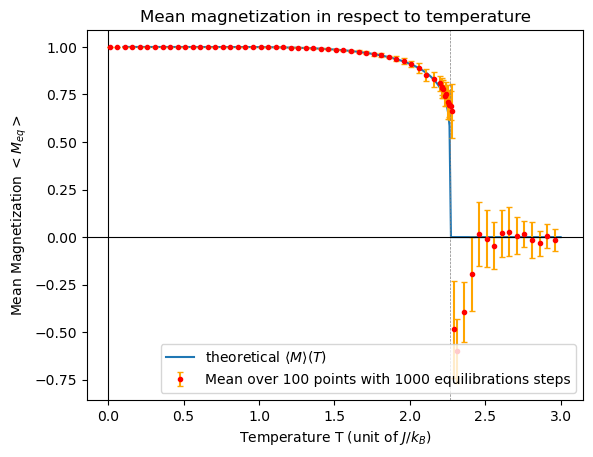

In [61]:
def magnetization(T, Tc=2.269, M_max=1):
    # For T < Tc
    if T < Tc:
        return M_max * (1 - 1 / (np.sinh(2 / T)**4))**(1/8)
    # For T >= Tc
    else:
        return 0

T_values = np.linspace(0.1, 3, 300)
plt.plot(T_values, M_values, label=r'theoretical $\langle M \rangle(T)$')

plt.errorbar(T_list, np.mean(M_list, axis=1), yerr=np.std(M_list, axis=1),
             fmt='o', color='red', markersize=3, 
             ecolor='orange', capsize=2,
             label='Mean over 100 points with 1000 equilibrations steps'
             )

Tc = 2.269 
plt.axvline(x=Tc, linestyle='--', linewidth=0.5, color='gray')

plt.axhline(y=0, color='black', linewidth=0.8)  # Horizontal axis (x-axis)
plt.axvline(x=0, color='black', linewidth=0.8)  # Vertical axis (y-axis)

plt.xlabel(r'Temperature T (unit of $J/k_B$)')
plt.ylabel(r'Mean Magnetization $<M_{eq}>$')
plt.title(r'Mean magnetization in respect to temperature')

plt.legend()

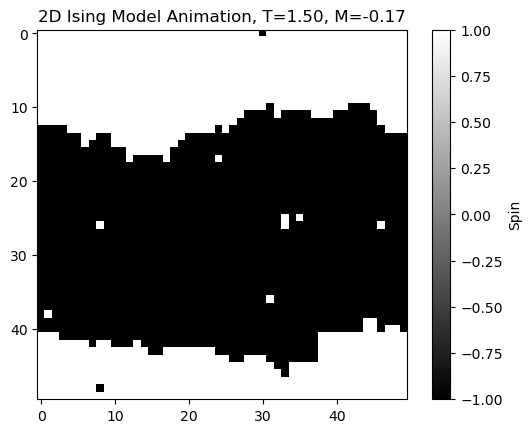

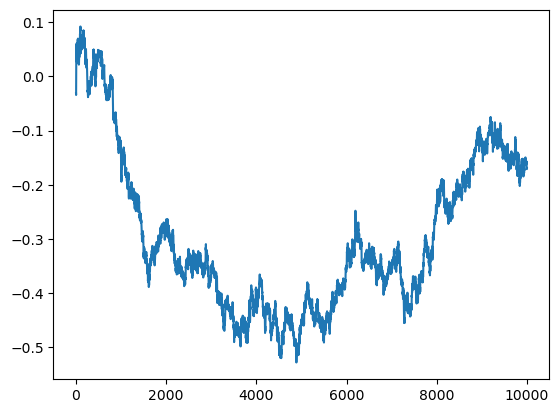

In [63]:
model = IsingModel(T=1.5)
model.simulate(10000)
model.plot()

plt.plot(model.M_frames)

In [ ]:
'''
# get the animation

model = IsingModel(N=50, kernel=kernels['first_neig'], T=10)
model.simulate(n_steps=200, save_frames=True)

HTML(model.animate().to_jshtml())


model1 = IsingModel(N=500, kernel=kernels['first_neig'], T=10)
#model2 = IsingModel(N=500, kernel=kernels['first_neig'], T=10, h=1)
#model3 = IsingModel(N=500, kernel=kernels['first_neig'], T=0.1, J=2, h=0.1)

model = model1

model.simulate(n_steps=200)
model.plot()
model.simulate(n_steps=200, Tf=0)
model.plot()
model.h=1
model.simulate(n_steps=200)

plt.plot(model.T_frames, label='Temperature')
plt.plot(model.h_frames, label='h (field)')
plt.legend()
plt.show()
'''